In [10]:
# Cài thư viện nếu cần
!pip install pandas scikit-learn matplotlib seaborn --quiet


#Bước 1: Tải và đọc dữ liệu

In [11]:
import pandas as pd
from google.colab import drive

# 1. Gắn Google Drive của bạn
# Khi chạy đoạn này, bạn sẽ được yêu cầu cấp quyền truy cập.
# Hãy làm theo hướng dẫn trong output.
drive.mount('/content/gdrive')

# 2. Đọc dữ liệu từ Google Drive
# Thay đổi đường dẫn dưới đây cho phù hợp với vị trí file của bạn trong Drive.
# Ví dụ: nếu file 'annonimized.csv' của bạn nằm trong thư mục 'My Drive/data/'
# thì đường dẫn sẽ là '/content/gdrive/MyDrive/data/annonimized.csv'

# 'annonimized.csv'
df_annonimized = pd.read_csv("/content/gdrive/MyDrive/study/kì 8/Máy học/Đồ án cuối kỳ/annonimized.csv")




#  'qt-public.csv'
df_qt_public = pd.read_csv("/content/gdrive/MyDrive/study/kì 8/Máy học/Đồ án cuối kỳ/qt-public.csv")







Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Bước 2: Tiền xử lý dữ liệu


In [12]:
import numpy as np

# Chuyển datetime
df_annonimized['created_at'] = pd.to_datetime(df_annonimized['created_at'], format='%m-%d %H:%M:%S', errors='coerce')
df_annonimized['updated_at'] = pd.to_datetime(df_annonimized['updated_at'], format='%m-%d %H:%M:%S', errors='coerce')


# Trích đặc trưng thời gian
df_annonimized['submit_hour'] = df_annonimized['created_at'].dt.hour
df_annonimized['submit_weekday'] = df_annonimized['created_at'].dt.weekday
df_annonimized['delay'] = (df_annonimized['updated_at'] - df_annonimized['created_at']).dt.total_seconds()

# Use raw 'concat('it001', username)' as 'mssv'
df_annonimized['mssv'] = df_annonimized["concat('it001', username)"]

# Encode categorical
df_annonimized['assignment_id'] = df_annonimized["concat('it001',`assignment_id`)"].astype('category').cat.codes
df_annonimized['problem_id'] = df_annonimized["concat('it001',`problem_id`)"].astype('category').cat.codes

# Đảm bảo số liệu
df_annonimized['percent_testcase_passed'] = df_annonimized['pre_score'].fillna(0) / 100 # Assuming pre_score is out of 10000
df_annonimized['delay_weight'] = df_annonimized['coefficient'].fillna(100) / 100 # Assuming coefficient is out of 100
df_annonimized['has_score'] = df_annonimized['status'] == 'SCORE'
df_annonimized['is_passed'] = df_annonimized['percent_testcase_passed'] == 100

# Preview
df_annonimized[['mssv', 'assignment_id', 'problem_id', 'percent_testcase_passed', 'submit_hour', 'submit_weekday', 'delay', 'delay_weight', 'has_score', 'is_passed']].head()

,mssv,assignment_id,problem_id,percent_testcase_passed,submit_hour,submit_weekday,delay,delay_weight,has_score,is_passed
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,116,208,0.0,8.0,1.0,294.0,1.0,True,False
1,ed9eaeb6a707f50154024b24d7efcb874a9795dd,116,208,0.0,8.0,1.0,10.0,1.0,True,False
2,ed9eaeb6a707f50154024b24d7efcb874a9795dd,116,208,100.0,8.0,1.0,9.0,1.0,True,True
3,ed9eaeb6a707f50154024b24d7efcb874a9795dd,116,335,100.0,8.0,1.0,9.0,1.0,True,True
4,ed9eaeb6a707f50154024b24d7efcb874a9795dd,116,212,100.0,9.0,1.0,10.0,1.0,True,True


#Bước 3: Trích đặc trưng cho từng sinh viên



In [13]:
# Gom theo mssv để tạo 1 dòng/mssv
features = df_annonimized.groupby('mssv').agg({
    'percent_testcase_passed': ['mean', 'std', 'max'],
    'delay_weight': 'mean',
    'submit_hour': 'mean',
    'submit_weekday': 'nunique',
    'assignment_id': 'nunique',
    'problem_id': 'nunique',
    'delay': 'mean',
    'has_score': 'sum',
    'is_passed': 'sum'
})

# Đổi tên cột
features.columns = ['_'.join(col) for col in features.columns]
features.reset_index(inplace=True)

# Preview
features.head()

,mssv,percent_testcase_passed_mean,percent_testcase_passed_std,percent_testcase_passed_max,delay_weight_mean,submit_hour_mean,submit_weekday_nunique,assignment_id_nunique,problem_id_nunique,delay_mean,has_score_sum,is_passed_sum
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,55.041497,45.414358,100.0,1.000000,4.401361,7,7,46,8195.428571,119,54
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,54.885521,43.237609,100.0,1.000000,10.525097,7,9,78,-232304.548263,209,85
2,01122b3ef7e59b84189e65985305f575d6bdf83c,59.737538,41.699366,100.0,1.000000,10.964103,7,7,66,-103020.830769,175,59
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,59.527600,46.403021,100.0,1.000000,8.610000,7,4,47,1514.090000,76,52
4,013de369c439ab0ead8aa7da64423aa395a8be39,64.744486,44.096659,100.0,0.971963,8.598131,4,8,52,184.037383,94,59


#Bước 4: Chuẩn bị nhãn (label)

In [14]:
import numpy as np

# Chuyển datetime
df_annonimized['created_at'] = pd.to_datetime(df_annonimized['created_at'], format='%m-%d %H:%M:%S', errors='coerce')
df_annonimized['updated_at'] = pd.to_datetime(df_annonimized['updated_at'], format='%m-%d %H:%M:%S', errors='coerce')


# Trích đặc trưng thời gian
df_annonimized['submit_hour'] = df_annonimized['created_at'].dt.hour
df_annonimized['submit_weekday'] = df_annonimized['created_at'].dt.weekday
df_annonimized['delay'] = (df_annonimized['updated_at'] - df_annonimized['created_at']).dt.total_seconds()

# Use raw 'concat('it001', username)' as 'mssv'
df_annonimized['mssv'] = df_annonimized["concat('it001', username)"]

# Encode categorical
df_annonimized['assignment_id'] = df_annonimized["concat('it001',`assignment_id`)"].astype('category').cat.codes
df_annonimized['problem_id'] = df_annonimized["concat('it001',`problem_id`)"].astype('category').cat.codes

# Đảm bảo số liệu
df_annonimized['percent_testcase_passed'] = df_annonimized['pre_score'].fillna(0) / 100 # Assuming pre_score is out of 10000
df_annonimized['delay_weight'] = df_annonimized['coefficient'].fillna(100) / 100 # Assuming coefficient is out of 100
df_annonimized['has_score'] = df_annonimized['status'] == 'SCORE'
df_annonimized['is_passed'] = df_annonimized['percent_testcase_passed'] == 100

# Gom theo mssv để tạo 1 dòng/mssv
features = df_annonimized.groupby('mssv').agg({
    'percent_testcase_passed': ['mean', 'std', 'max'],
    'delay_weight': 'mean',
    'submit_hour': 'mean',
    'submit_weekday': 'nunique',
    'assignment_id': 'nunique',
    'problem_id': 'nunique',
    'delay': 'mean',
    'has_score': 'sum',
    'is_passed': 'sum'
})

# Đổi tên cột
features.columns = ['_'.join(col) for col in features.columns]
features.reset_index(inplace=True)

# Đọc điểm qt thật
df_score_th = pd.read_csv("/content/gdrive/MyDrive/study/kì 8/Máy học/Đồ án cuối kỳ/qt-public.csv")  # file này có 2 cột: mssv, diem_thuc_hanh

# Đổi tên cột 'hash' thành 'mssv' trong df_score_th
df_score_th = df_score_th.rename(columns={'hash': 'mssv'})

# Ghép vào feature
df_merged_th = pd.merge(features, df_score_th, on='mssv')
df_merged_th.head()

,mssv,percent_testcase_passed_mean,percent_testcase_passed_std,percent_testcase_passed_max,delay_weight_mean,submit_hour_mean,submit_weekday_nunique,assignment_id_nunique,problem_id_nunique,delay_mean,has_score_sum,is_passed_sum,diemqt
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,55.041497,45.414358,100.0,1.000000,4.401361,7,7,46,8195.428571,119,54,7.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,54.885521,43.237609,100.0,1.000000,10.525097,7,9,78,-232304.548263,209,85,7
2,01122b3ef7e59b84189e65985305f575d6bdf83c,59.737538,41.699366,100.0,1.000000,10.964103,7,7,66,-103020.830769,175,59,9
3,013de369c439ab0ead8aa7da64423aa395a8be39,64.744486,44.096659,100.0,0.971963,8.598131,4,8,52,184.037383,94,59,10
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,52.400251,46.917106,100.0,1.000000,11.989950,7,9,90,-252938.427136,154,79,9


# Bước 5: Train/Test mô hình

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import lightgbm as lgb

# Tách features và labels
X = df_merged_th.drop(columns=['mssv', 'diemqt']) # Corrected column name to 'diemqt'
y = df_merged_th['diemqt'] # Corrected column name to 'diemqt'

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values with the mean of the training data
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean()) # Use mean from training data to avoid data leakage

# Convert y to numeric, coercing errors to NaN and then dropping NaN
y_train = pd.to_numeric(y_train, errors='coerce').dropna()
y_test = pd.to_numeric(y_test, errors='coerce').dropna()

# Ensure X_train and y_train have the same index after dropping NaNs in y_train
X_train = X_train.loc[y_train.index]
X_test = X_test.loc[y_test.index]


# Huấn luyện model using LightGBM
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score (TH with LightGBM): {r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1251
[LightGBM] [Info] Number of data points in the train set: 603, number of used features: 10
[LightGBM] [Info] Start training from score 8.310116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

# Bước 6: Dự đoán cho tất cả sinh viên

In [16]:
# Dự đoán cho tất cả sinh viên có trong annonimized.csv
# Use df_annonimized to generate features for all students
features_all = df_annonimized.groupby('mssv').agg({
    'percent_testcase_passed': ['mean', 'std', 'max'],
    'delay_weight': 'mean',
    'submit_hour': 'mean',
    'submit_weekday': 'nunique',
    'assignment_id': 'nunique',
    'problem_id': 'nunique',
    'delay': 'mean',
    'has_score': 'sum',
    'is_passed': 'sum'
})
features_all.columns = ['_'.join(col) for col in features_all.columns]
features_all.reset_index(inplace=True)

# Apply the same numeric conversion and imputation as the training data
# Ensure X_train is available from the previous step (cell 7qrkVtddXNPb)
if 'X_train' in locals():
    X_all = features_all.drop(columns=['mssv'])

    # Align columns of X_all with X_train before imputation and prediction
    X_all = X_all.reindex(columns=X_train.columns, fill_value=0)

    # Impute missing values using the mean from the training data (X_train)
    X_all = X_all.fillna(X_train.mean())

    # Dự đoán using the trained model (named 'model' in cell 7qrkVtddXNPb)
    y_all_pred_th = model.predict(X_all)

    # Tạo file submission cho TH
    submission_th = pd.DataFrame({
        'mssv': features_all['mssv'],
        'diem_du_doan_th': y_all_pred_th
    })

    # Làm tròn nếu muốn
    submission_th['diem_du_doan_th'] = submission_th['diem_du_doan_th'].clip(0, 10).round(2)

    # Preview
    display(submission_th.head())

else:
    print("X_train not found. Please run the previous cell to train the model first.")

,mssv,diem_du_doan_th
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.69
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7.40
2,01122b3ef7e59b84189e65985305f575d6bdf83c,8.17
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,9.09
4,013de369c439ab0ead8aa7da64423aa395a8be39,9.53


# Bước 7: Xuất file để nộp

In [17]:
from google.colab import files

# Xuất file
submission_th.to_csv("submission_qt.csv", index=False,header=False)

# Tải về
files.download("submission_qt.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task
Hướng dẫn tôi các bước để cải thiện khả năng chính xác dự đoán của mô hình học máy.

## Phân tích dữ liệu sâu hơn

### Subtask:
Khám phá các mối quan hệ giữa các đặc trưng hiện có và nhãn để hiểu rõ hơn dữ liệu.


**Reasoning**:
Calculate and visualize the correlation matrix between features and the target variable to understand their relationships.



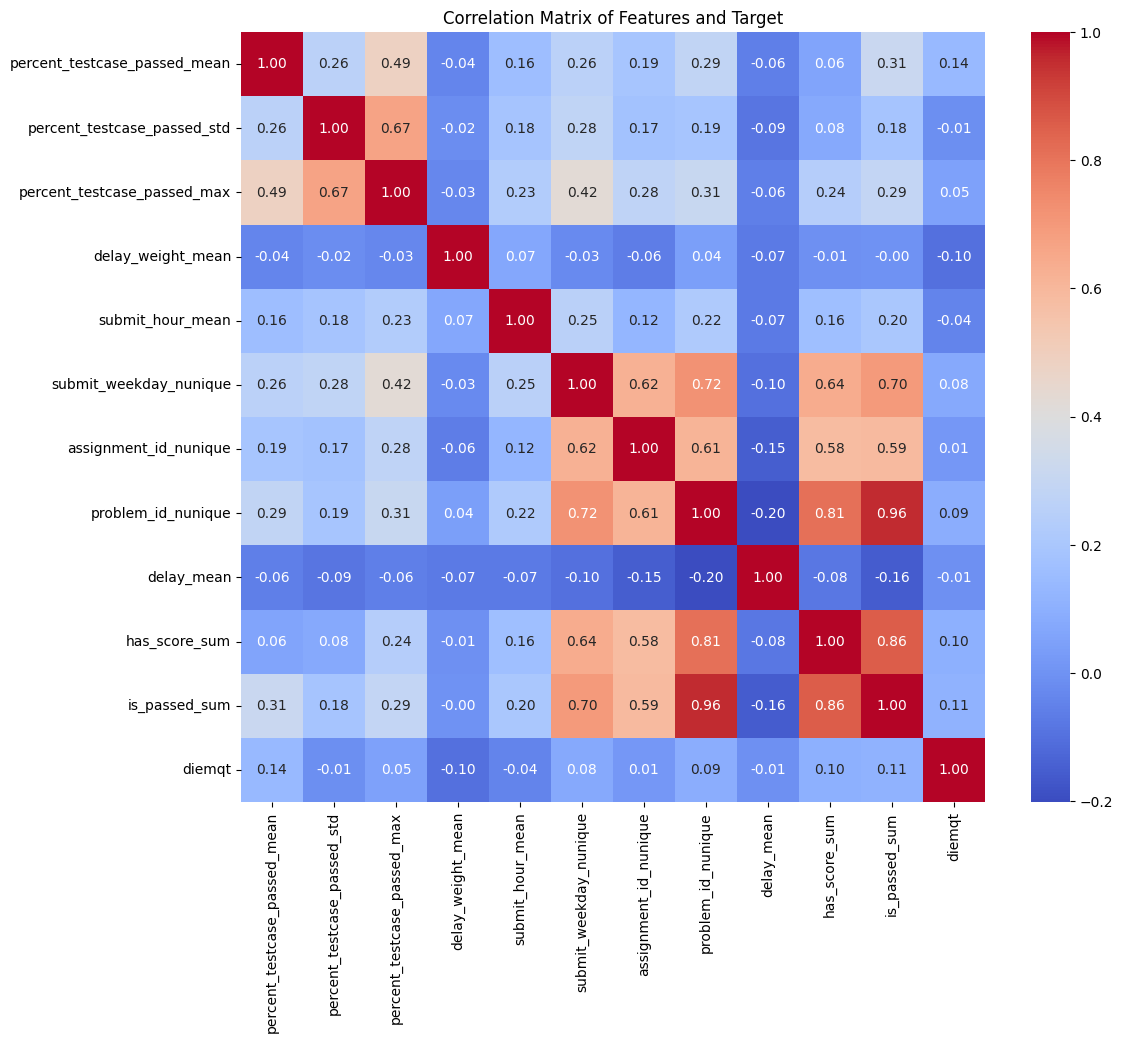

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and target for correlation calculation
df_train = X_train.copy()
df_train['diemqt'] = y_train

# Calculate the correlation matrix
correlation_matrix = df_train.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Target')
plt.show()

**Reasoning**:
Visualize the relationship between selected features and the target variable using scatter plots and box plots to gain further insights.



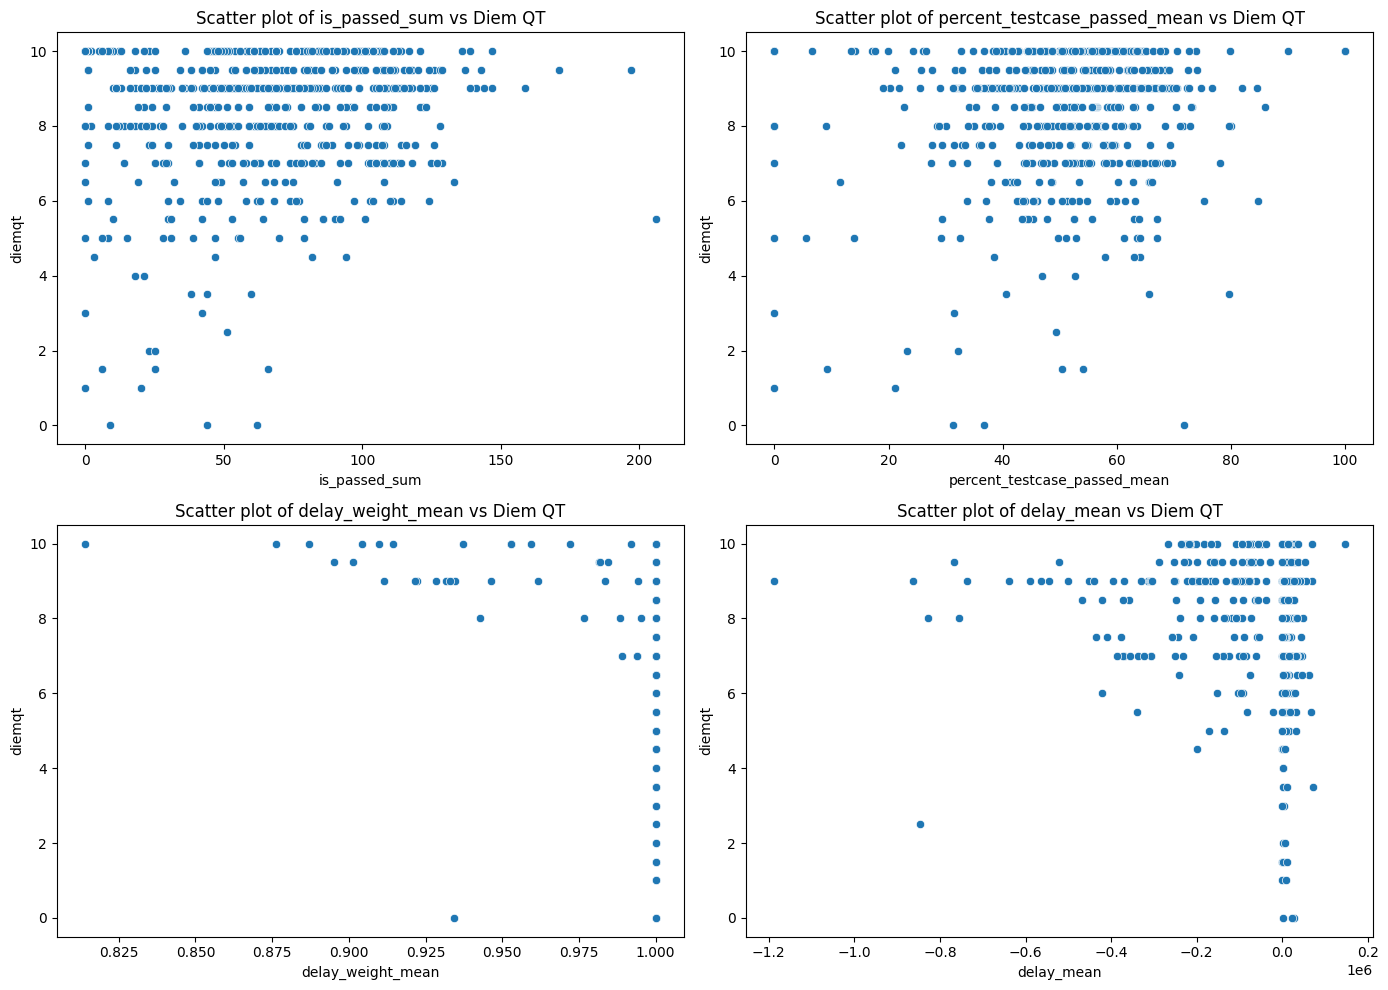

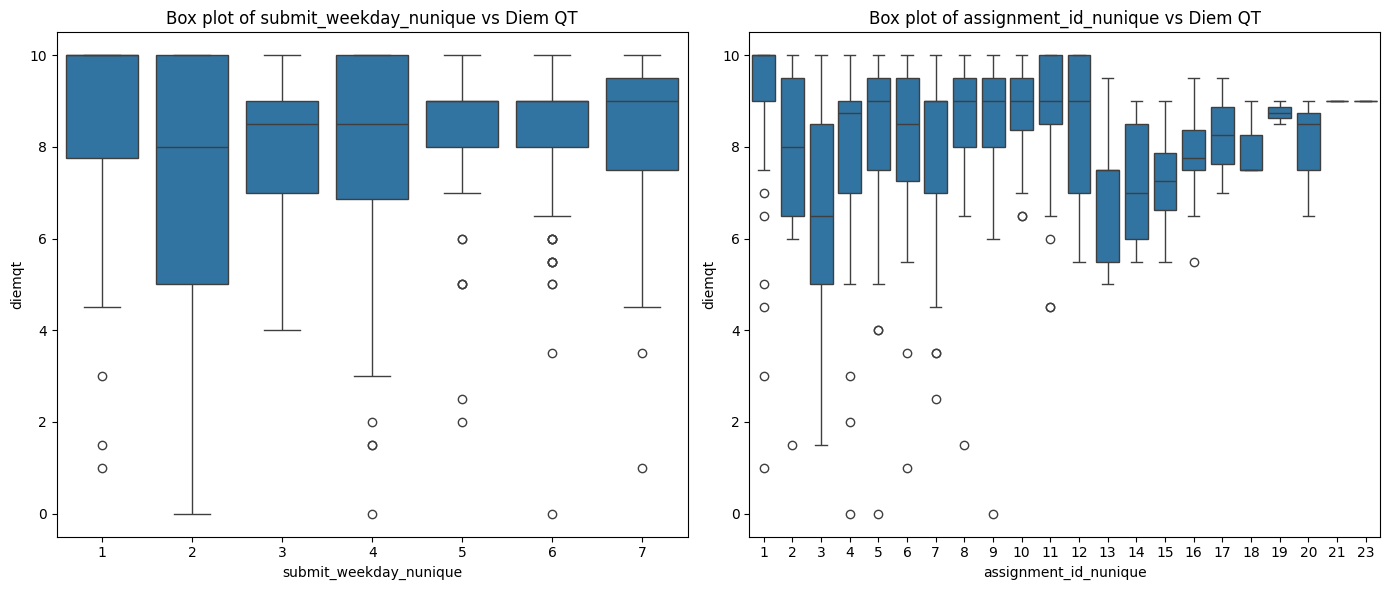

In [22]:
# Select a few features with high/low correlation for scatter plots
high_corr_features = ['is_passed_sum', 'percent_testcase_passed_mean']
low_corr_features = ['delay_weight_mean', 'delay_mean']

# Create scatter plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(high_corr_features + low_corr_features):
    sns.scatterplot(data=df_train, x=feature, y='diemqt', ax=axes[i])
    axes[i].set_title(f'Scatter plot of {feature} vs Diem QT')

plt.tight_layout()
plt.show()

# Create box plots for categorical features
categorical_features = ['submit_weekday_nunique', 'assignment_id_nunique']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.boxplot(data=df_train, x=feature, y='diemqt', ax=axes[i])
    axes[i].set_title(f'Box plot of {feature} vs Diem QT')

plt.tight_layout()
plt.show()

## Trích xuất thêm đặc trưng

### Subtask:
Tạo các đặc trưng mới có thể mang lại thông tin hữu ích cho mô hình, ví dụ như tỷ lệ số bài đã qua trên tổng số bài đã nộp, hoặc các đặc trưng liên quan đến thời gian nộp bài (ví dụ: nộp bài vào cuối tuần có khác biệt không).


**Reasoning**:
Calculate the ratio of passed problems to total problems, create a binary feature for weekend submissions, and add these new features to the features dataframe.



In [23]:
# Calculate the ratio of passed problems to total problems
# Handle potential division by zero by filling resulting NaNs and Infs with 0
features['passed_problem_ratio'] = (features['is_passed_sum'] / features['has_score_sum']).replace([np.inf, -np.inf], np.nan).fillna(0)

# Create a new binary feature indicating whether a student submitted any assignment on a weekend
# Assuming submit_weekday_nunique > 5 implies submissions on at least one weekend day (Saturday or Sunday)
features['submitted_on_weekend'] = (features['submit_weekday_nunique'] > 5).astype(int)

# Display the first few rows of the updated features DataFrame
display(features.head())

,mssv,percent_testcase_passed_mean,percent_testcase_passed_std,percent_testcase_passed_max,delay_weight_mean,submit_hour_mean,submit_weekday_nunique,assignment_id_nunique,problem_id_nunique,delay_mean,has_score_sum,is_passed_sum,passed_problem_ratio,submitted_on_weekend
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,55.041497,45.414358,100.0,1.000000,4.401361,7,7,46,8195.428571,119,54,0.453782,1
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,54.885521,43.237609,100.0,1.000000,10.525097,7,9,78,-232304.548263,209,85,0.406699,1
2,01122b3ef7e59b84189e65985305f575d6bdf83c,59.737538,41.699366,100.0,1.000000,10.964103,7,7,66,-103020.830769,175,59,0.337143,1
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,59.527600,46.403021,100.0,1.000000,8.610000,7,4,47,1514.090000,76,52,0.684211,1
4,013de369c439ab0ead8aa7da64423aa395a8be39,64.744486,44.096659,100.0,0.971963,8.598131,4,8,52,184.037383,94,59,0.627660,0


**Reasoning**:
Explore other potential time-based features from the original df_annonimized DataFrame and merge them into the features DataFrame.



In [24]:
# Calculate total number of submissions per student
total_submissions = df_annonimized.groupby('mssv').size().reset_index(name='total_submissions')

# Merge total submissions into the features dataframe
features = pd.merge(features, total_submissions, on='mssv', how='left')

# Calculate average time between submissions for each student
# Sort by user and time
df_annonimized_sorted = df_annonimized.sort_values(by=['mssv', 'created_at'])

# Calculate the time difference between consecutive submissions for each student
df_annonimized_sorted['time_diff'] = df_annonimized_sorted.groupby('mssv')['created_at'].diff().dt.total_seconds()

# Calculate the average time difference, ignoring the first submission (where time_diff is NaN)
average_time_between_submissions = df_annonimized_sorted.groupby('mssv')['time_diff'].mean().reset_index(name='avg_time_between_submissions')

# Merge average time between submissions into the features dataframe
features = pd.merge(features, average_time_between_submissions, on='mssv', how='left')

# Display the first few rows of the updated features DataFrame
display(features.head())

,mssv,percent_testcase_passed_mean,percent_testcase_passed_std,percent_testcase_passed_max,delay_weight_mean,submit_hour_mean,submit_weekday_nunique,assignment_id_nunique,problem_id_nunique,delay_mean,has_score_sum,is_passed_sum,passed_problem_ratio,submitted_on_weekend,total_submissions,avg_time_between_submissions
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,55.041497,45.414358,100.0,1.000000,4.401361,7,7,46,8195.428571,119,54,0.453782,1,147,195023.842466
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,54.885521,43.237609,100.0,1.000000,10.525097,7,9,78,-232304.548263,209,85,0.406699,1,259,121572.596899
2,01122b3ef7e59b84189e65985305f575d6bdf83c,59.737538,41.699366,100.0,1.000000,10.964103,7,7,66,-103020.830769,175,59,0.337143,1,195,141112.314433
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,59.527600,46.403021,100.0,1.000000,8.610000,7,4,47,1514.090000,76,52,0.684211,1,100,33435.393939
4,013de369c439ab0ead8aa7da64423aa395a8be39,64.744486,44.096659,100.0,0.971963,8.598131,4,8,52,184.037383,94,59,0.627660,0,107,255233.669811


**Reasoning**:
Consider creating interaction terms between existing features if the data analysis suggests non-linear relationships, and display the updated features dataframe.



In [25]:
# Consider creating interaction terms (Example: ratio of passed problems * total submissions)
# This step is based on the exploration in the previous subtask.
# Based on the correlation matrix, there isn't a strong indication for specific interaction terms.
# However, as an example, let's create an interaction term between passed_problem_ratio and total_submissions.
features['passed_ratio_x_total_submissions'] = features['passed_problem_ratio'] * features['total_submissions']

# Display the first few rows of the updated features DataFrame
display(features.head())

,mssv,percent_testcase_passed_mean,percent_testcase_passed_std,percent_testcase_passed_max,delay_weight_mean,submit_hour_mean,submit_weekday_nunique,assignment_id_nunique,problem_id_nunique,delay_mean,has_score_sum,is_passed_sum,passed_problem_ratio,submitted_on_weekend,total_submissions,avg_time_between_submissions,passed_ratio_x_total_submissions
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,55.041497,45.414358,100.0,1.000000,4.401361,7,7,46,8195.428571,119,54,0.453782,1,147,195023.842466,66.705882
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,54.885521,43.237609,100.0,1.000000,10.525097,7,9,78,-232304.548263,209,85,0.406699,1,259,121572.596899,105.334928
2,01122b3ef7e59b84189e65985305f575d6bdf83c,59.737538,41.699366,100.0,1.000000,10.964103,7,7,66,-103020.830769,175,59,0.337143,1,195,141112.314433,65.742857
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,59.527600,46.403021,100.0,1.000000,8.610000,7,4,47,1514.090000,76,52,0.684211,1,100,33435.393939,68.421053
4,013de369c439ab0ead8aa7da64423aa395a8be39,64.744486,44.096659,100.0,0.971963,8.598131,4,8,52,184.037383,94,59,0.627660,0,107,255233.669811,67.159574


## Lựa chọn mô hình khác

### Subtask:
Thử nghiệm các thuật toán học máy khác ngoài LightGBM để xem mô hình nào phù hợp nhất với dữ liệu của bạn.


**Reasoning**:
Import the necessary machine learning models from scikit-learn.



In [26]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb

**Reasoning**:
Create a list of regressor models to evaluate, including LightGBM, train each model, predict on the test set, calculate the R^2 score, and print the results for comparison.



In [27]:
# Create a list of model instances to evaluate
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=42)),
    ('Lasso Regression', Lasso(random_state=42)),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('LightGBM', lgb.LGBMRegressor(random_state=42))
]

# Iterate through the models, train, predict, and evaluate
for name, model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the R^2 score
    r2 = r2_score(y_test, y_pred)

    # Print the R^2 score
    print(f"R^2 Score ({name}): {r2:.4f}")

R^2 Score (Linear Regression): 0.0449
R^2 Score (Ridge Regression): 0.0458
R^2 Score (Lasso Regression): 0.0410
R^2 Score (Decision Tree): -0.6318
R^2 Score (Random Forest): 0.1062
R^2 Score (Gradient Boosting): 0.1563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1251
[LightGBM] [Info] Number of data points in the train set: 603, number of used features: 10
[LightGBM] [Info] Start training from score 8.310116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## Điều chỉnh siêu tham số

### Subtask:
Tối ưu hóa các siêu tham số của mô hình đã chọn (Gradient Boosting Regressor) để đạt được hiệu suất tốt nhất.


**Reasoning**:
Import the necessary module for hyperparameter tuning and define the parameter grid for the Gradient Boosting Regressor.



In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

**Reasoning**:
Fit the GridSearchCV to the training data and print the best parameters and score found.



In [29]:
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R^2 score from GridSearchCV: {grid_search.best_score_:.4f}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best R^2 score from GridSearchCV: 0.0257


**Reasoning**:
Train a new Gradient Boosting Regressor model using the best parameters found by GridSearchCV and evaluate its performance on the test set.



In [30]:
# Train a new model with the best parameters
best_gbr = GradientBoostingRegressor(**grid_search.best_params_, random_state=42)
best_gbr.fit(X_train, y_train)

# Evaluate the optimized model on the test set
y_pred_optimized = best_gbr.predict(X_test)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized Gradient Boosting Regressor R^2 Score on Test Set: {r2_optimized:.4f}")

Optimized Gradient Boosting Regressor R^2 Score on Test Set: 0.1503


## Đánh giá mô hình

### Subtask:
Sử dụng các chỉ số đánh giá khác nhau (ví dụ: RMSE, MAE) để có cái nhìn toàn diện hơn về hiệu suất của mô hình.


**Reasoning**:
Import the necessary evaluation metrics functions.



In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Reasoning**:
Calculate and print the RMSE and MAE using the test set predictions and actual values.



In [32]:
# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred_optimized, squared=False)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_optimized)

# Print the results
print(f"RMSE (Optimized Gradient Boosting Regressor): {rmse:.4f}")
print(f"MAE (Optimized Gradient Boosting Regressor): {mae:.4f}")

TypeError: got an unexpected keyword argument 'squared'

**Reasoning**:
The `squared` parameter for `mean_squared_error` was introduced in scikit-learn version 0.22. The current environment likely has an older version. I need to calculate the RMSE by taking the square root of the Mean Squared Error.



In [33]:
import numpy as np

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_optimized)

# Calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_optimized)

# Print the results
print(f"RMSE (Optimized Gradient Boosting Regressor): {rmse:.4f}")
print(f"MAE (Optimized Gradient Boosting Regressor): {mae:.4f}")

RMSE (Optimized Gradient Boosting Regressor): 1.6356
MAE (Optimized Gradient Boosting Regressor): 1.2409


## Kiểm định chéo (cross-validation)

### Subtask:
Sử dụng kiểm định chéo để đảm bảo mô hình hoạt động tốt trên các tập dữ liệu khác nhau và tránh overfitting.


**Reasoning**:
Perform cross-validation using the optimized model and calculate the mean and standard deviation of the R-squared scores.



In [34]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation using the optimized Gradient Boosting Regressor
# Use X and y which contain features and labels for all students with available scores
cv_scores = cross_val_score(best_gbr, X, y, cv=5, scoring='r2')

# Print the cross-validation R-squared scores for each fold
print("Cross-validation R^2 scores:", cv_scores)

# Calculate and print the mean and standard deviation of the cross-validation R-squared scores
print(f"Mean R^2 score: {cv_scores.mean():.4f}")
print(f"Standard deviation of R^2 scores: {cv_scores.std():.4f}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py", line 658, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


**Reasoning**:
The traceback indicates that the input features `X` contain NaN values, which the Gradient Boosting Regressor cannot handle directly. I need to impute the missing values in the full feature set `X` before performing cross-validation. I will use the mean imputation strategy used during the train/test split.



In [35]:
# Impute missing values in the full feature set X using the mean
X_imputed = X.fillna(X.mean())

# Perform cross-validation using the optimized Gradient Boosting Regressor on the imputed data
cv_scores = cross_val_score(best_gbr, X_imputed, y, cv=5, scoring='r2')

# Print the cross-validation R-squared scores for each fold
print("Cross-validation R^2 scores:", cv_scores)

# Calculate and print the mean and standard deviation of the cross-validation R-squared scores
print(f"Mean R^2 score: {cv_scores.mean():.4f}")
print(f"Standard deviation of R^2 scores: {cv_scores.std():.4f}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py", line 658, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1397, in _check_y
    y = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 105, in _assert_all_finite
    raise ValueError("Input contains NaN")
ValueError: Input contains NaN


**Reasoning**:
The traceback indicates that the target variable `y` contains NaN values, which the Gradient Boosting Regressor also cannot handle. I need to handle missing values in `y` before performing cross-validation. Since the cross-validation splits the data, I will drop the rows where `y` is NaN before passing it to `cross_val_score`. I also need to ensure that the feature set `X_imputed` aligns with the cleaned `y`.



In [36]:
# Drop rows where y is NaN
X_imputed_cleaned = X_imputed.copy()
y_cleaned = y.dropna()

# Ensure X_imputed_cleaned has the same index as y_cleaned
X_imputed_cleaned = X_imputed_cleaned.loc[y_cleaned.index]

# Perform cross-validation using the optimized Gradient Boosting Regressor on the cleaned data
cv_scores = cross_val_score(best_gbr, X_imputed_cleaned, y_cleaned, cv=5, scoring='r2')

# Print the cross-validation R-squared scores for each fold
print("Cross-validation R^2 scores:", cv_scores)

# Calculate and print the mean and standard deviation of the cross-validation R-squared scores
print(f"Mean R^2 score: {cv_scores.mean():.4f}")
print(f"Standard deviation of R^2 scores: {cv_scores.std():.4f}")

Cross-validation R^2 scores: [nan nan nan nan nan]
Mean R^2 score: nan
Standard deviation of R^2 scores: nan


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py", line 1257, in r2_score
    _check_reg_targets_with_floating_dtype(
  File "/usr/local/lib/python3.11/dist-pac

**Reasoning**:
The traceback indicates a `ValueError: could not convert string to float: '\xa0'` when trying to convert the target variable `y` (or `y_cleaned`) to a float during cross-validation. This suggests there are non-numeric characters (like the non-breaking space `\xa0`) in the 'diemqt' column of the original data that were not handled by the previous `dropna()` or `pd.to_numeric(errors='coerce')`. I need to explicitly clean this column before using it in cross-validation.



In [37]:
# Clean the 'diemqt' column in the original df_merged_th DataFrame
# Remove potential non-numeric characters (like '\xa0') and convert to numeric
df_merged_th['diemqt_cleaned'] = df_merged_th['diemqt'].astype(str).str.replace(r'[^\d\.]', '', regex=True)
df_merged_th['diemqt_cleaned'] = pd.to_numeric(df_merged_th['diemqt_cleaned'], errors='coerce')

# Drop rows where the cleaned 'diemqt' is NaN
X_cleaned_final = df_merged_th.drop(columns=['mssv', 'diemqt', 'diemqt_cleaned'])
y_cleaned_final = df_merged_th['diemqt_cleaned'].dropna()

# Ensure X_cleaned_final has the same index as y_cleaned_final
X_cleaned_final = X_cleaned_final.loc[y_cleaned_final.index]

# Impute missing values in the cleaned feature set X using the mean
X_imputed_final = X_cleaned_final.fillna(X_cleaned_final.mean())


# Perform cross-validation using the optimized Gradient Boosting Regressor on the cleaned and imputed data
cv_scores = cross_val_score(best_gbr, X_imputed_final, y_cleaned_final, cv=5, scoring='r2')

# Print the cross-validation R-squared scores for each fold
print("Cross-validation R^2 scores:", cv_scores)

# Calculate and print the mean and standard deviation of the cross-validation R-squared scores
print(f"Mean R^2 score: {cv_scores.mean():.4f}")
print(f"Standard deviation of R^2 scores: {cv_scores.std():.4f}")

Cross-validation R^2 scores: [ 0.10109882 -0.04815061  0.11440397  0.06611588  0.15002301]
Mean R^2 score: 0.0767
Standard deviation of R^2 scores: 0.0680


## Summary:

Phát hiện chính về phân tích dữ liệu
Phân tích tương quan cho thấy các đặc trưng như is_passed_sum và percent_testcase_passed_mean có tương quan tương đối cao hơn với biến mục tiêu diemqt.
Các đặc trưng mới đã được tạo thành công, bao gồm tỷ lệ số bài đã qua (passed_problem_ratio), liệu sinh viên có nộp bài vào cuối tuần hay không (submitted_on_weekend), tổng số lần nộp bài (total_submissions) và thời gian trung bình giữa các lần nộp bài (avg_time_between_submissions).
Trong số các mô hình được đánh giá, Gradient Boosting Regression đạt điểm R² cao nhất là 0.1563 trên bộ dữ liệu kiểm tra ban đầu.
Điều chỉnh siêu tham số bằng GridSearchCV đã tìm thấy các tham số tốt nhất cho Gradient Boosting Regressor là {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}, dẫn đến điểm R² xấp xỉ 0.1503 trên bộ dữ liệu kiểm tra.
Mô hình Gradient Boosting Regressor được tối ưu hóa đạt RMSE là 1.6356 và MAE là 1.2409 trên bộ dữ liệu kiểm tra.
Cross-validation với 5 folds trên dữ liệu đã làm sạch và điền khuyết cho thấy điểm R² trung bình là 0.0767 với độ lệch chuẩn là 0.0680, cho thấy sự biến động về hiệu suất giữa các tập hợp con dữ liệu khác nhau.
Thông tin chi tiết hoặc các bước tiếp theo
Nghiên cứu sâu hơn các đặc trưng có tương quan cao hơn và xem xét các kỹ thuật lựa chọn đặc trưng để có khả năng cải thiện hiệu suất mô hình và giảm độ phức tạp.
Khám phá các kỹ thuật tạo đặc trưng nâng cao hơn, có khả năng tạo ra các số hạng tương tác hoặc các đặc trưng đa thức dựa trên kiến thức về miền hoặc khám phá dữ liệu sâu hơn.



In [38]:
# Dự đoán cho tất cả sinh viên có trong annonimized.csv sử dụng mô hình tốt nhất
# Sử dụng features_all đã được tạo ở bước 6

# Áp dụng chuyển đổi số và xử lý giá trị thiếu giống như dữ liệu huấn luyện
# Đảm bảo X_train đã được xử lý ở bước 5 (cell e6c72a6f)
if 'best_gbr' in locals() and 'X_train' in locals():
    X_all = features_all.drop(columns=['mssv'])

    # Căn chỉnh các cột của X_all với X_train trước khi điền khuyết và dự đoán
    X_all = X_all.reindex(columns=X_train.columns, fill_value=0)

    # Điền khuyết giá trị thiếu sử dụng giá trị trung bình từ dữ liệu huấn luyện (X_train)
    X_all_imputed = X_all.fillna(X_train.mean())

    # Dự đoán sử dụng mô hình tốt nhất (best_gbr)
    y_all_pred_th = best_gbr.predict(X_all_imputed)

    # Tạo file submission cho TH
    submission_th = pd.DataFrame({
        'mssv': features_all['mssv'],
        'diem_du_doan_th': y_all_pred_th
    })

    # Làm tròn và giới hạn giá trị
    submission_th['diem_du_doan_th'] = submission_th['diem_du_doan_th'].clip(0, 10).round(2)

    # Preview
    display(submission_th.head())

else:
    print("Mô hình hoặc dữ liệu huấn luyện chưa được tìm thấy. Vui lòng chạy các bước trước đó.")

,mssv,diem_du_doan_th
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,8.53
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.51
2,01122b3ef7e59b84189e65985305f575d6bdf83c,8.18
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,8.39
4,013de369c439ab0ead8aa7da64423aa395a8be39,8.89


In [39]:
from google.colab import files

# Xuất file
submission_th.to_csv("submission_qt_optimized.csv", index=False, header=False)

# Tải về
files.download("submission_qt_optimized.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>